# **12 Deep Learning(T)**

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math
import torch.nn.functional as F
import time
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

## **<span style='color:#EA7500	'>Enabling and testing the GPU on Google Colab</span>**

Enable GPUs for the notebook:

- Navigate to Edit (編輯)→Notebook Settings (筆記本設定)
- select GPU from the Hardware Accelerator drop-down (在硬體加速器選擇"T4 GPU")

In [2]:
!nvidia-smi

Mon Dec 11 14:04:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P8              21W / 170W |   5827MiB /  6144MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--


## **<span style='color:#EA7500	'>Tensors</span>**


In [3]:
x = torch.tensor([5.5, 3])
print('x: ', x)

y = np.array([5.5, 3])
print('y: ', y)

x:  tensor([5.5000, 3.0000])
y:  [5.5 3. ]


In [4]:
x = torch.zeros((5, 3), dtype=torch.float)
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [5]:
print(x.shape)

torch.Size([5, 3])


## **<span style='color:#EA7500	'>Operations</span>**


- ### **Arithmetic**

In [6]:
x = torch.linspace(1, 10, 10)
y = torch.ones((1, 10))

print(x+y)

tensor([[ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])



- ### **Indexing & Slincing**


In [7]:
print(x[:5])

tensor([1., 2., 3., 4., 5.])



- ### **Resizing**

#### Note: Use `torch.view` if you want to resize/reshape tensor.

In [8]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.shape, y.shape, z.shape)

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


#### Note: If you have a one element tensor, use ``.item()`` to get the value as a Python number.

In [9]:
x = torch.randn(1)
print(x)
print(x.item())

tensor([0.4934])
0.4933909773826599


## **<span style='color:#EA7500	'>NumPy Bridge</span>**
#### Converting a Torch Tensor to a NumPy array and vice versa is a breeze.

The Torch Tensor and NumPy array will share their underlying memory
locations (if the Torch Tensor is on CPU),   
and changing one will change
the other.


- ### **NumPy Array → Torch Tensor**


In [10]:
a = np.ones(5)
b = torch.from_numpy(a)
print(a)
print(b)

[1. 1. 1. 1. 1.]
tensor([1., 1., 1., 1., 1.], dtype=torch.float64)



- ### **Torch Tensor → NumPy Array**


In [11]:
a = torch.ones(5)
print(a)
b = a.numpy()
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


In [12]:
a.add_(1)
print(a)
print(b)

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]



## **<span style='color:#EA7500	'>Tensors | CUDA</span>**
#### Tensors can be moved onto any device using the ``.to`` method.

Let us run this cell only if CUDA is available
We will use ``torch.device`` objects to move tensors in and out of GPU.

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    y = torch.ones_like(x, device=device)
    x = x.to(device)                        # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))        # ``.to`` can also change dtype together!

tensor([1.4934], device='cuda:0')
tensor([1.4934], dtype=torch.float64)


In [14]:
x.cpu().numpy()

array([0.49339098], dtype=float32)


## **<span style='color:#EA7500	'>What is PyTorch?</span>**


In [15]:
import torch

torch.__version__

'2.1.1+cu121'

In [16]:
nb_iters = 100

for device in ['cpu', 'cuda']:
    for s in torch.logspace(1, 8, steps=8).int():
        img = torch.randint(0, 256, (s,), device=device).float()
        torch.cuda.synchronize()
        t0 = time.time()
        for _ in range(nb_iters):
            out = torch.histc(img, bins=256)
        torch.cuda.synchronize()
        t1 = time.time()
        print('device {}, size {}, time {}'.format(
            device, s, (t1 - t0)/nb_iters))



device cpu, size 10, time 3.989934921264648e-05
device cpu, size 100, time 1.9941329956054688e-05
device cpu, size 1000, time 4.985809326171875e-05
device cpu, size 10000, time 9.974479675292969e-05
device cpu, size 100000, time 0.00035904645919799806
device cpu, size 1000000, time 0.002283895015716553
device cpu, size 10000000, time 0.022190659046173095
device cpu, size 100000000, time 0.23134644985198974
device cuda, size 10, time 0.00031914949417114255
device cuda, size 100, time 0.00026927471160888674
device cuda, size 1000, time 0.00026927947998046876
device cuda, size 10000, time 0.00034907102584838865
device cuda, size 100000, time 0.0005090165138244628
device cuda, size 1000000, time 0.0013663411140441895
device cuda, size 10000000, time 0.0010674262046813964
device cuda, size 100000000, time 0.00618377685546875


## **<span style='color:#EA7500	'>Artificial Neural Networks</span>**

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

- ### **Step 1: Load the dataset**

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

(1797, 8, 8)

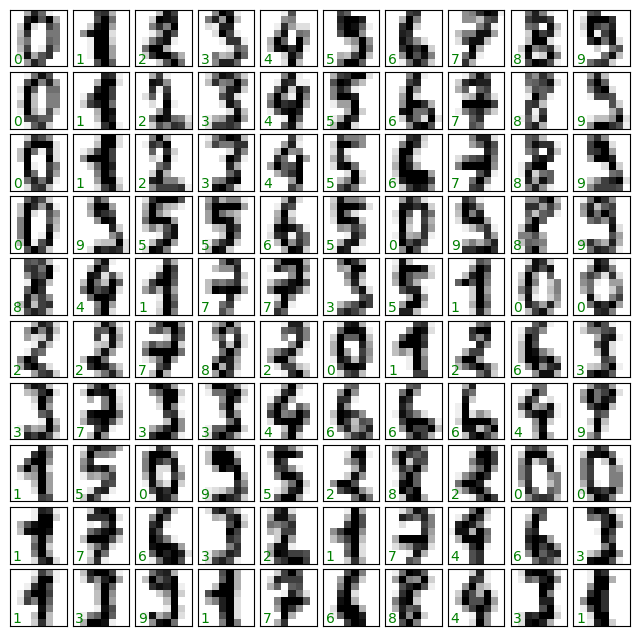

In [18]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print('X_train_tensor type:', type(X_train_tensor) )
print('X_train_tensor shape:', X_train_tensor.shape )
print('y_train_tensor type:', type(y_train_tensor) )
print('y_train_tensor shape: ', y_train_tensor.shape )

X_train_tensor type: <class 'torch.Tensor'>
X_train_tensor shape: torch.Size([1437, 64])
y_train_tensor type: <class 'torch.Tensor'>
y_train_tensor shape:  torch.Size([1437])


In [20]:
y = torch.tensor(digits.target, dtype=torch.long)
print(y)

tensor([0, 1, 2,  ..., 8, 9, 8])



- ### **Step 2: Define the network**

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNet(nn.Module):

    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [22]:
model = TwoLayerNet()
print('Model architecture:')
print(model)
# print(list(model.parameters()))
for layer in model.parameters():
    print(layer)
    print(layer.shape)

Model architecture:
TwoLayerNet(
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)
Parameter containing:
tensor([[-0.0804, -0.0170,  0.0689,  ..., -0.0315, -0.0272, -0.0605],
        [-0.1072, -0.0103,  0.0994,  ...,  0.0411,  0.0399, -0.0090],
        [ 0.0748, -0.0472,  0.0733,  ...,  0.0006, -0.0783, -0.0280],
        ...,
        [-0.0812, -0.0861, -0.1029,  ..., -0.0942, -0.0669, -0.1097],
        [ 0.0418, -0.0732, -0.0853,  ...,  0.0220,  0.0114, -0.0276],
        [ 0.0816, -0.1050, -0.0272,  ..., -0.0847, -0.0754,  0.1073]],
       requires_grad=True)
torch.Size([32, 64])
Parameter containing:
tensor([ 0.0554, -0.0623, -0.1015, -0.1004,  0.0591,  0.0145,  0.0060, -0.0522,
         0.0029, -0.0626,  0.0689,  0.0570,  0.0625, -0.1149,  0.1038, -0.0910,
        -0.1091, -0.0540, -0.1115,  0.0308,  0.0589,  0.1240, -0.0738,  0.0079,
        -0.0036,  0.0097, -0.1232,  0.0480, -0.0159,  0.0360,  0.1102, 


- ### **Step 3: Define a Loss function and optimizer**

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epoch = 100

- ### **Step 4: Train the model**

In [24]:
training_loss = []
training_accuracy = []
for t in range(epoch):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_train_tensor)

    # Compute and print loss
    loss = criterion(y_pred, y_train_tensor)
    acc = torch.sum(torch.argmax(y_pred, dim=1)==y_train_tensor) / y_train_tensor.shape[0]
    if t % 10 == 9:
        print('Epoach', t+1)
        print('loss: ', loss.item())
        print('accuracy: ', acc.numpy())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())
    training_accuracy.append(acc)

Epoach 10
loss:  1.912657618522644
accuracy:  0.35421017
Epoach 20
loss:  1.4821865558624268
accuracy:  0.55671537
Epoach 30
loss:  1.130531907081604
accuracy:  0.7341684
Epoach 40
loss:  0.8708595633506775
accuracy:  0.8051496
Epoach 50
loss:  0.7010464668273926
accuracy:  0.8434238
Epoach 60
loss:  0.5861327052116394
accuracy:  0.87125957
Epoach 70
loss:  0.5039032101631165
accuracy:  0.8914405
Epoach 80
loss:  0.4423083961009979
accuracy:  0.9039666
Epoach 90
loss:  0.394922137260437
accuracy:  0.91162145
Epoach 100
loss:  0.35796797275543213
accuracy:  0.9171886


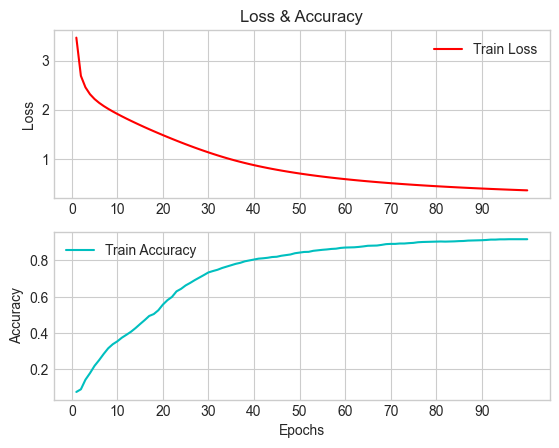

In [25]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

plt.subplot(2, 1, 1)
plt.title("Loss & Accuracy")
plt.ylabel("Loss")
plt.plot(range(1, len(training_loss)+1), training_loss, label="Train Loss", color='r')
plt.xticks(np.arange(0, epoch, 10.0), )
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, len(training_accuracy)+1), training_accuracy, label="Train Accuracy", color='c')
plt.plot()
plt.xticks(np.arange(0, epoch, 10.0), )
plt.legend()

# plt.savefig('./results/Loss_Acc.jpg')
plt.show()

- ### **Step 5: Test the model on the test data**

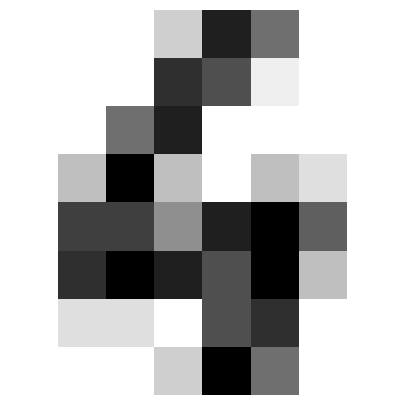

True label:  4
Predicted label:  4


In [26]:
i = 3
plt.figure(figsize=(5,5))
plt.imshow(X_test[i].reshape(8, 8), cmap='binary')
plt.axis('off')
plt.show()
print('True label: ', y_test[i])

with torch.no_grad():
    x_test_tensor = X_test_tensor[i]
    y_pred = model(x_test_tensor)

    print('Predicted label: ', y_pred.argmax().item())

In [27]:
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().argmax(axis=1)
    result = (y_pred == y_test).astype(int).sum()

print('Accuracy of the model on the %d test images: %.2f %%' % (len(y_test), 100 * result/len(y_test)))

Accuracy of the model on the 360 test images: 90.83 %


In [46]:
# util functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # print("Normalized confusion matrix")
    else:
        pass # print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

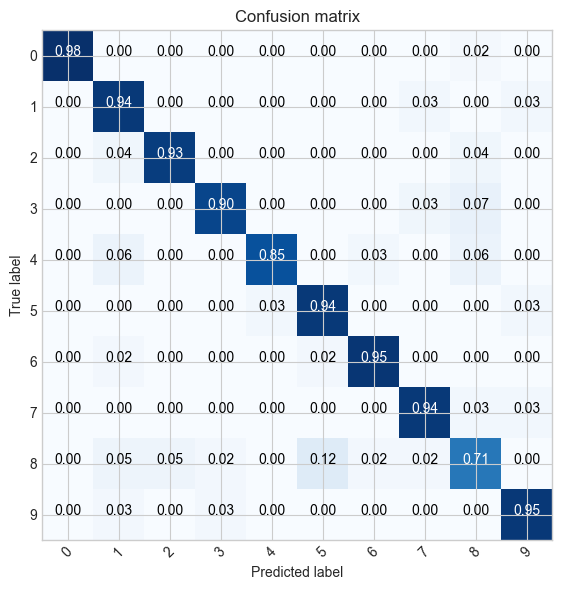

In [48]:
from sklearn.metrics import confusion_matrix

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, classes=classes, normalize=True)


## **<span style='color:#EA7500	'>Convolutional Neural Network</span>**


- ### **Step 1: Load MNIST dataset**

The reason why we don't use the same dataset as above is that the shape ofthat matrix is (1437, 64) which is not fit to this model. Although this dataset still can be used if do some modification, we choose another dataset which is more easier for both using and understanding.

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [31]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [32]:
print('Train_data shape:', train_data.data.shape)
print('Train_data image shape', train_data[0][0].shape)

Train_data shape: torch.Size([60000, 28, 28])
Train_data image shape torch.Size([1, 28, 28])


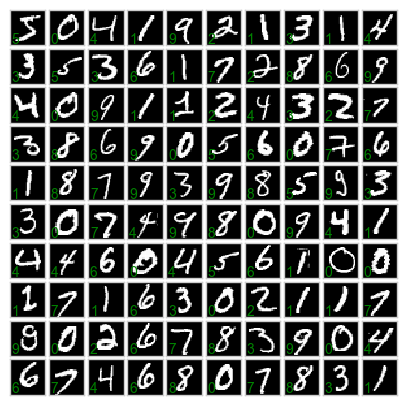

In [33]:
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    img, label = train_data[i]
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    ax.text(0.05, 0.05, str(label), transform=ax.transAxes, color='green')

- ### **Step 2: Defining the parameters**

In [34]:
test_size = 0.2
batch_size = 100
num_workers = 0

- ### **Step 3: Preparing data loaders**

In [35]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

- ### **Step 4: Classes in MNIST dataset (digits 0-9)**

In [36]:
classes = [str(i) for i in range(10)]

- ### **Step 5: Adjusting the convolution and pooling layers**

In [37]:
def Conv_Width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def Pool_Width(W, F, S):
    return math.floor((W - F) / S + 1)

def Conv_Pool_Width(W, F, P, S, F2, S2, n):
    for i in range(n):
        W = Pool_Width(Conv_Width(W, F, P, S), F2, S2)
    return W

Adjusted_width = Conv_Pool_Width(28, 3, 1, 1, 2, 2, 3)

- ### **Step 6: Defining the CNN model**

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1)  # Single channel for grayscale MNIST images
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv3 = nn.Conv2d(20, 40, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(40 * Adjusted_width * Adjusted_width, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 40 * Adjusted_width * Adjusted_width)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

- ### **Step 7: Checking if GPU is available**

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


- ### **Step 8: Defining loss function and optimizer**

In [40]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

- ### **Step 9: Training the model**

In [41]:
epochs = 2  # Reduced the number of epochs to 2 for a quick run; you might need to increase this.
train_losses, valid_losses = [], []

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1}/{epochs},\
      Training Loss: {train_loss:.3f}')

Epoch: 1/2,      Training Loss: 0.470
Epoch: 2/2,      Training Loss: 0.121


- **Plot Loss graph if you need.**

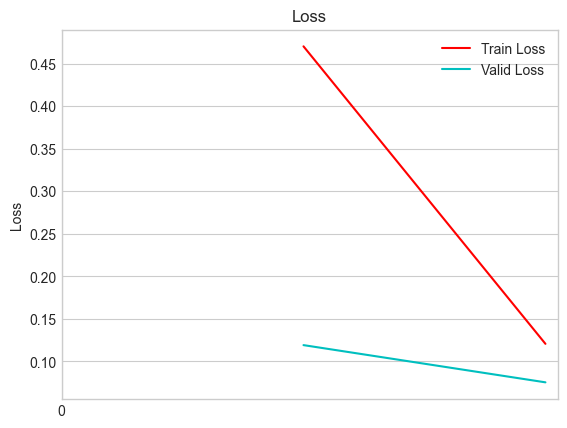

In [42]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

# plt.subplot(2, 1, 1)
plt.title("Loss")
plt.ylabel("Loss")
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", color='r')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label="Valid Loss", color='c')
plt.xticks(np.arange(0, epochs, 10.0), )
plt.legend()
plt.show()

- ### **Step 10: Testing the model**

In [43]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss:.3f}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}% ({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})')
    else:
        print(f'Test Accuracy of {i}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

Test Loss: 0.060

Test Accuracy of 0: 98.88% (969/980)
Test Accuracy of 1: 98.77% (1121/1135)
Test Accuracy of 2: 99.32% (1025/1032)
Test Accuracy of 3: 97.52% (985/1010)
Test Accuracy of 4: 98.37% (966/982)
Test Accuracy of 5: 98.54% (879/892)
Test Accuracy of 6: 98.54% (944/958)
Test Accuracy of 7: 96.69% (994/1028)
Test Accuracy of 8: 97.74% (952/974)
Test Accuracy of 9: 97.62% (985/1009)

Test Accuracy (Overall): 98.20% (9820/10000)


## **<span style='color:#EDA0A9	'>Exercise</span>**
1. Plot the training history of the CNN, including training and validation accuracy as well as loss.
2. Print the weights and biases of the first convolutional layer in the trained CNN. What observations can you make?
3. Plot the confusion matrix for the test dataset.